In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv('unique750.csv')

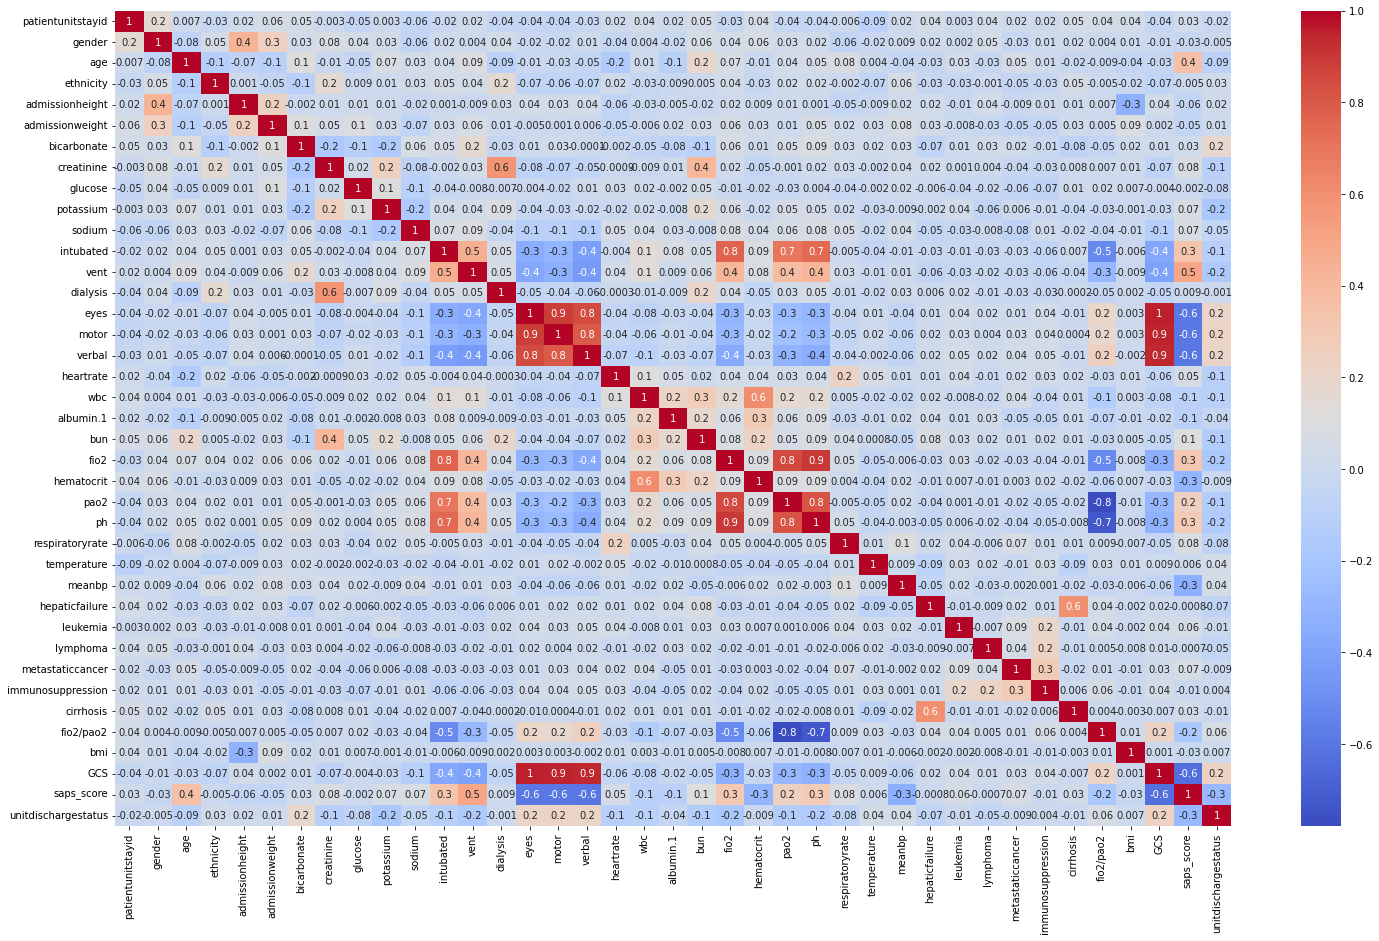

In [31]:
cor = df.corr()
plt.figure(figsize=(25,15))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt='.0g');

In [32]:
df.columns

Index(['patientunitstayid', 'gender', 'age', 'ethnicity', 'apacheadmissiondx',
       'admissionheight', 'admissionweight', 'bicarbonate', 'creatinine',
       'glucose', 'potassium', 'sodium', 'intubated', 'vent', 'dialysis',
       'eyes', 'motor', 'verbal', 'heartrate', 'wbc', 'albumin.1', 'bun',
       'fio2', 'hematocrit', 'pao2', 'ph', 'respiratoryrate', 'temperature',
       'meanbp', 'hepaticfailure', 'leukemia', 'lymphoma', 'metastaticcancer',
       'immunosuppression', 'cirrhosis', 'fio2/pao2', 'bmi', 'GCS',
       'type_of_admission', 'saps_score', 'unitdischargestatus'],
      dtype='object')

Feature Selection

Here we are performing chi-squre feature selection

In [33]:
from sklearn import datasets
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [34]:
X = df[[ 'gender','ethnicity', 'vent', 'dialysis',
        'hepaticfailure', 'leukemia', 'lymphoma', 'metastaticcancer',
       'immunosuppression', 'cirrhosis']]
y = df['unitdischargestatus']

In [35]:
chi_scores = chi2(X,y)
chi_scores

(array([1.85991659e-02, 4.12155249e+00, 3.67257054e+01, 2.81790474e-03,
        8.70227162e+00, 2.43726082e-01, 5.10103899e+00, 1.20345599e-01,
        2.77252755e-02, 3.45933304e-01]),
 array([8.91521865e-01, 4.23402066e-02, 1.35974617e-09, 9.57665027e-01,
        3.17813745e-03, 6.21527800e-01, 2.39115166e-02, 7.28659961e-01,
        8.67756334e-01, 5.56424265e-01]))

In [36]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

<AxesSubplot:>

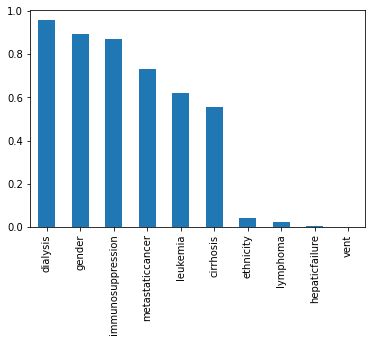

In [37]:
p_values.plot.bar()

In [38]:
p_values

dialysis             9.576650e-01
gender               8.915219e-01
immunosuppression    8.677563e-01
metastaticcancer     7.286600e-01
leukemia             6.215278e-01
cirrhosis            5.564243e-01
ethnicity            4.234021e-02
lymphoma             2.391152e-02
hepaticfailure       3.178137e-03
vent                 1.359746e-09
dtype: float64

We will only ethnicity, lymphoma, hepaticsfailure, and vent for categorical data in our future prediction.

Then we are performating mutal information feature selection.

In [39]:
from sklearn.model_selection import train_test_split

X2 = df[[ 'age', 'bicarbonate', 'potassium','heartrate', 'wbc', 
'albumin.1', 'bun', 'creatinine','glucose', 'hematocrit',
'respiratoryrate','sodium', 'temperature', 'meanbp', 'fio2/pao2', 'bmi', 'GCS',  'saps_score']]


X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (1357, 18) (1357,)
Test (340, 18) (340,)


In [40]:
# Determine how many features we should select

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=mutual_info_classif, k=7)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 95.59


Using seven features provide the highest accuracy in logistic regression 

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
for n in range(10):
	# feature selection
	X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
	# what are scores for the features
	#for i in range(len(fs.scores_)):
	fea_df = pd.DataFrame({'feature':fs.feature_names_in_, 'scores':fs.scores_})
	print(fea_df.nlargest(7, 'scores'))

        feature    scores
17   saps_score  0.038893
16          GCS  0.030200
1   bicarbonate  0.020368
7    creatinine  0.019664
13       meanbp  0.018851
6           bun  0.016360
8       glucose  0.015321
        feature    scores
17   saps_score  0.045244
16          GCS  0.033771
13       meanbp  0.019065
1   bicarbonate  0.017616
12  temperature  0.017269
14    fio2/pao2  0.014992
7    creatinine  0.014808
        feature    scores
17   saps_score  0.037171
16          GCS  0.025941
13       meanbp  0.021457
1   bicarbonate  0.018504
7    creatinine  0.015923
12  temperature  0.014350
6           bun  0.013483
            feature    scores
17       saps_score  0.042588
16              GCS  0.037202
12      temperature  0.024373
13           meanbp  0.023412
7        creatinine  0.016867
1       bicarbonate  0.016055
10  respiratoryrate  0.009056
        feature    scores
17   saps_score  0.045266
16          GCS  0.028035
13       meanbp  0.019682
7    creatinine  0.016432
12  te

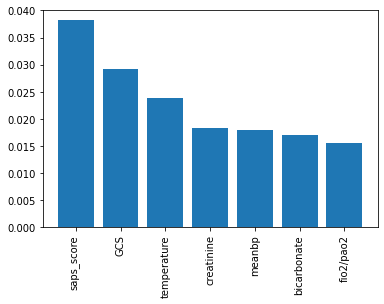

In [42]:
# plot the scores
fea_df_final = pd.DataFrame({'feature': ['saps_score', 'GCS', 'temperature', 'creatinine', 'meanbp', 'bicarbonate', 'fio2/pao2'],
                            'score': [0.038197, 0.029282, 0.023921, 0.018288, 0.017926, 0.017072, 0.01560]})
fea_df_final                        
plt.bar(fea_df_final['feature'],fea_df_final['score'])
plt.xticks(rotation=90)
plt.show()

After 10 interations, we found that the most frequent seven highest correlated feature is ['temperature', 'meanbp','GCS',  'saps_score','bicarbonate','creatinine','fio2/pao2']